In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2

2025-05-12 17:48:49.154216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747072129.400444      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747072129.477470      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Paths
base_dir = '/kaggle/input/labeled-chest-xray-images/chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = '/kaggle/working/val'  # Writable directory

In [5]:
# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create validation set (20% of training data) in /kaggle/working/
def create_validation_set(train_dir, val_dir, split_ratio=0.2):
    if not os.path.exists(val_dir):
        os.makedirs(os.path.join(val_dir, 'NORMAL'), exist_ok=True)
        os.makedirs(os.path.join(val_dir, 'PNEUMONIA'), exist_ok=True)
        for cls in ['NORMAL', 'PNEUMONIA']:
            images = os.listdir(os.path.join(train_dir, cls))
            train_imgs, val_imgs = train_test_split(images, test_size=split_ratio, random_state=42)
            for img in val_imgs:
                # Copy instead of move to preserve original data
                shutil.copy(os.path.join(train_dir, cls, img), os.path.join(val_dir, cls, img))
    else:
        print("Validation directory already exists. Skipping creation.")

create_validation_set(train_dir, val_dir)


In [6]:
# Count images in each class
def count_images(directory):
    normal_count = len(os.listdir(os.path.join(directory, 'NORMAL')))
    pneumonia_count = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return normal_count, pneumonia_count

train_normal, train_pneumonia = count_images(train_dir)
val_normal, val_pneumonia = count_images(val_dir)
test_normal, test_pneumonia = count_images(test_dir)

print(f"Train - Normal: {train_normal}, Pneumonia: {train_pneumonia}")
print(f"Validation - Normal: {val_normal}, Pneumonia: {val_pneumonia}")
print(f"Test - Normal: {test_normal}, Pneumonia: {test_pneumonia}")

Train - Normal: 1349, Pneumonia: 3883
Validation - Normal: 270, Pneumonia: 777
Test - Normal: 234, Pneumonia: 390


In [7]:
# Calculate class weights for imbalance
class_weights = {
    0: (train_normal + train_pneumonia) / (2 * train_normal),  # Normal
    1: (train_normal + train_pneumonia) / (2 * train_pneumonia)  # Pneumonia
}
print("Class weights:", class_weights)

Class weights: {0: 1.939214232765011, 1: 0.6737058975019315}


In [8]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 5232 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
# Build ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


2025-05-12 17:53:50.769105: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [10]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Callbacks
os.makedirs('/kaggle/working/weights', exist_ok=True)
checkpoint = ModelCheckpoint(
    '/kaggle/working/weights/pneumonia_model_epoch_{epoch:02d}.weights.h5',
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='auto'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)


In [12]:
# Load latest weights if available
weight_files = sorted([f for f in os.listdir('/kaggle/working/weights') if f.endswith('.weights.h5')])
if weight_files:
    latest_weights = os.path.join('/kaggle/working/weights', weight_files[-1])
    print(f"Loading weights from {latest_weights}")
    model.load_weights(latest_weights)
else:
    print("No previous weights found. Training from scratch.")


No previous weights found. Training from scratch.


In [13]:
# Train model
history = model.fit(
    train_generator,
    epochs=7,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 621s 4s/step - accuracy: 0.7275 - loss: 0.5438 - val_accuracy: 0.7278 - val_loss: 0.5958 - learning_rate: 5.0000e-05
Epoch 2/7
164/164 ━━━━━━━━━━━━━━━━━━━━ 596s 4s/step - accuracy: 0.7603 - loss: 0.4884 - val_accuracy: 0.7421 - val_loss: 0.6172 - learning_rate: 5.0000e-05
Epoch 3/7
164/164 ━━━━━━━━━━━━━━━━━━━━ 595s 4s/step - accuracy: 0.7900 - loss: 0.4217 - val_accuracy: 0.6342 - val_loss: 0.6855 - learning_rate: 5.0000e-05
Epoch 4/7
164/164 ━━━━━━━━━━━━━━━━━━━━ 680s 4s/step - accuracy: 0.7757 - loss: 0.4300 - val_accuracy: 0.4804 - val_loss: 0.9374 - learning_rate: 1.0000e-05
Epoch 5/7
164/164 ━━━━━━━━━━━━━━━━━━━━ 630s 4s/step - accuracy: 0.7935 - loss: 0.4252 - val_accuracy: 0.6886 - val_loss: 0.6263 - learning_rate: 1.0000e-05
Epoch 6/7
164/164 ━━━━━━━━━━━━━━━━━━━━ 626s 4s/step - accuracy: 0.7913 - loss: 0.4141 - val_accuracy: 0.6543 - val_loss: 0.6812 - learning_rate: 2.0000e-06
Epoch 7/7
164/164 ━━━━━━━━━━━━━━━━━━━━ 622s 4s/step - accuracy: 0.8130 - l

In [14]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.8623 - loss: 0.3316
Test Loss: 0.4311, Test Accuracy: 0.8221


In [15]:
# Predictions and metrics
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.71      0.90      0.79       234
   Pneumonia       0.93      0.77      0.84       390

    accuracy                           0.82       624
   macro avg       0.82      0.84      0.82       624
weighted avg       0.85      0.82      0.82       624



In [16]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.close()

In [17]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/roc_curve.png')
plt.close()

In [20]:
# Save final model
try:
    model.save('/kaggle/working/pneumonia_detection_final.h5')
except Exception as e:
    print(f"Error saving final model: {e}")

✅ Model loaded successfully.
[1] NORMAL-1049278-0001.jpeg: Normal (89.43%)
[2] NORMAL-1110860-0001.jpeg: Normal (95.28%)
[3] NORMAL-11419-0001.jpeg: Normal (86.02%)


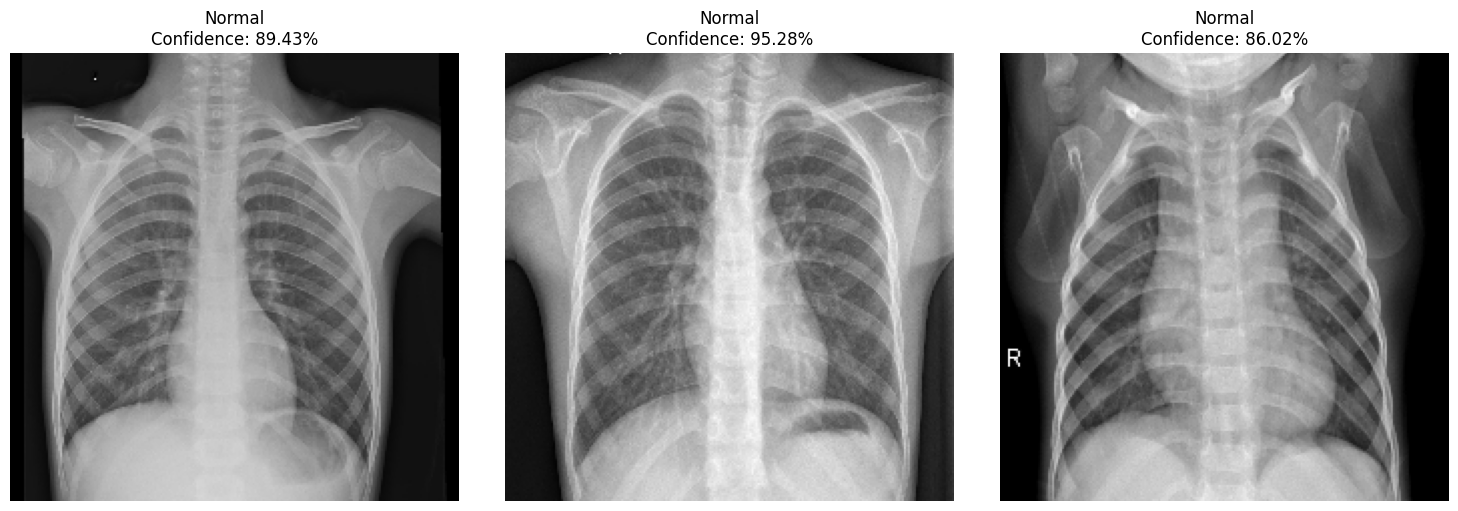

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model

# Constants
IMG_SIZE = (224, 224)
MODEL_PATH = '/kaggle/working/pneumonia_detection_final.h5'

# Sample test image paths (use actual pneumonia images if needed)
IMAGE_PATHS = [
    '/kaggle/input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-1049278-0001.jpeg',
    '/kaggle/input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-1110860-0001.jpeg',
    '/kaggle/input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-11419-0001.jpeg'
]

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

# Function to predict image class
def predict_image(model, image):
    img_input = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(img_input, verbose=0)[0][0]
    label = 'Pneumonia' if prediction > 0.5 else 'Normal'
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return label, float(confidence)

# Load model
try:
    model = load_model(MODEL_PATH)
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ Failed to load model: {e}")
    model = None

# Predict and display
if model:
    plt.figure(figsize=(15, 5))
    for i, path in enumerate(IMAGE_PATHS):
        try:
            img = load_and_preprocess_image(path)
            label, confidence = predict_image(model, img)

            # Display
            plt.subplot(1, len(IMAGE_PATHS), i + 1)
            plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
            plt.title(f'{label}\nConfidence: {confidence:.2%}')
            plt.axis('off')

            print(f"[{i+1}] {os.path.basename(path)}: {label} ({confidence:.2%})")

        except Exception as e:
            print(f"⚠️ Error processing {path}: {e}")

    plt.tight_layout()
    plt.savefig('/kaggle/working/prediction_results.png')
    plt.show()
else:
    print("❌ Cannot proceed: Model not loaded.")


✅ Model loaded successfully.
[1] BACTERIA-1135262-0004.jpeg - True: PNEUMONIA, Predicted: Pneumonia (68.68%) → Correct
[2] NORMAL-7031638-0001.jpeg - True: NORMAL, Predicted: Normal (88.82%) → Correct
[3] BACTERIA-7136666-0001.jpeg - True: PNEUMONIA, Predicted: Normal (57.86%) → Incorrect
[4] NORMAL-1212407-0001.jpeg - True: NORMAL, Predicted: Normal (90.80%) → Correct
[5] NORMAL-3396581-0001.jpeg - True: NORMAL, Predicted: Normal (79.24%) → Correct
[6] VIRUS-9476607-0001.jpeg - True: PNEUMONIA, Predicted: Pneumonia (63.10%) → Correct

✅ Accuracy on sampled test images: 83.33%


/tmp/ipykernel_31/1552168979.py:81: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31/1552168979.py:81: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31/1552168979.py:82: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.savefig('/kaggle/working/random_sample_predictions.png')
/tmp/ipykernel_31/1552168979.py:82: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.savefig('/kaggle/working/random_sample_predictions.png')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


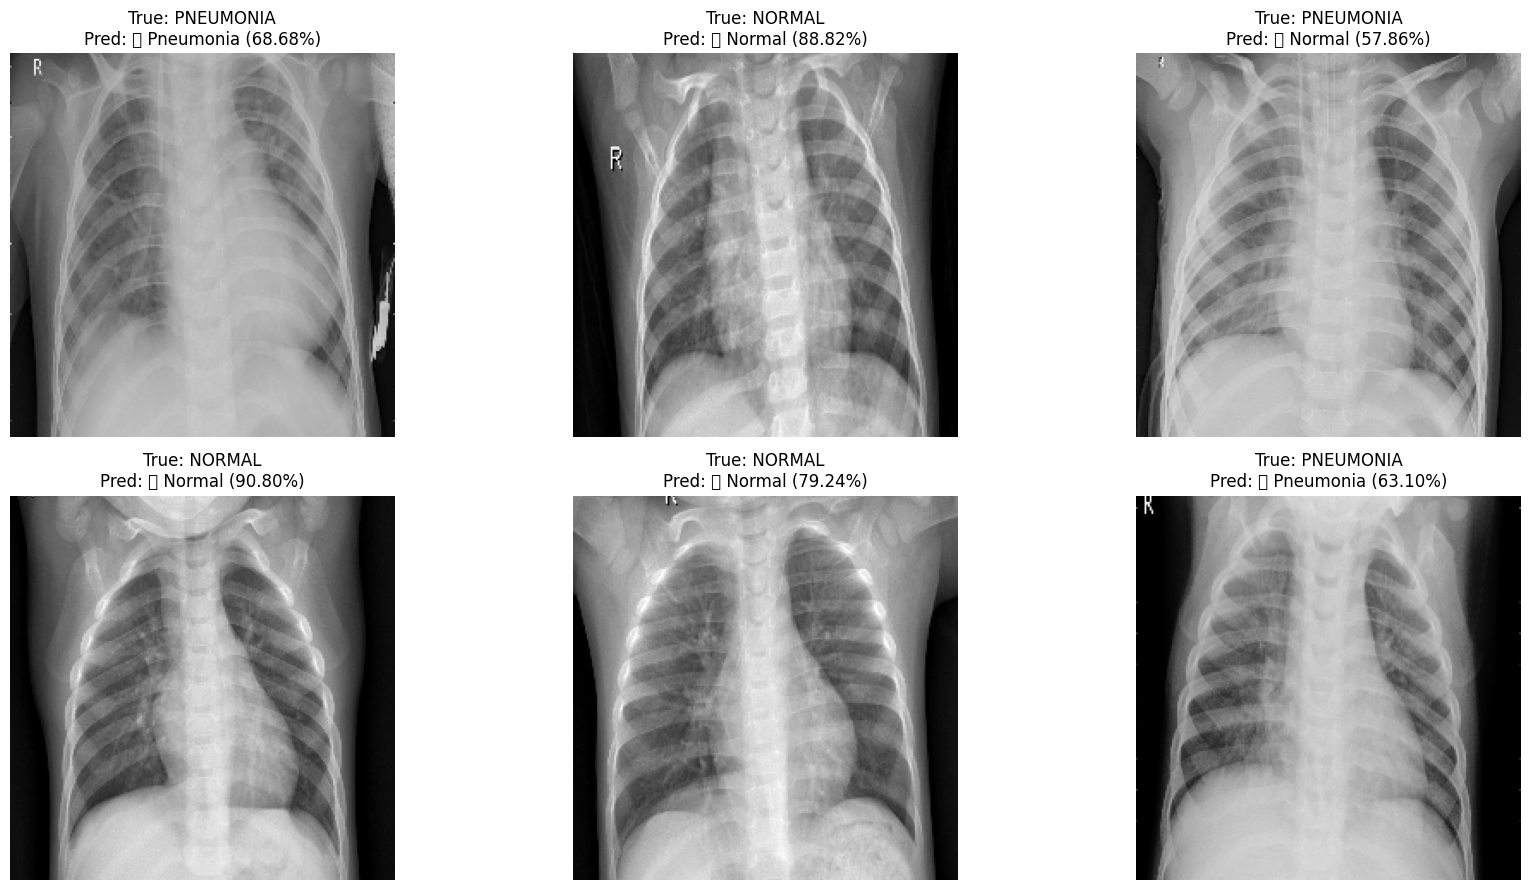

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.models import load_model

# Constants
IMG_SIZE = (224, 224)
TEST_DIR = '/kaggle/input/labeled-chest-xray-images/chest_xray/test'
MODEL_PATH = '/kaggle/working/pneumonia_detection_final.h5'
CLASSES = ['NORMAL', 'PNEUMONIA']
NUM_SAMPLES = 6  # Number of random images to test

# Load model
try:
    model = load_model(MODEL_PATH)
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ Failed to load model: {e}")
    model = None

# Helper: Preprocess image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

# Helper: Predict
def predict_image(model, image):
    img_input = np.expand_dims(image, axis=0)
    prediction = model.predict(img_input, verbose=0)[0][0]
    label = 'Pneumonia' if prediction > 0.5 else 'Normal'
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return label, float(confidence)

# Sample and evaluate
if model:
    all_images = []
    for cls in CLASSES:
        folder = os.path.join(TEST_DIR, cls)
        image_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
        sampled_files = random.sample(image_files, NUM_SAMPLES // 2)
        for path in sampled_files:
            all_images.append((path, cls))

    random.shuffle(all_images)

    # Display predictions
    plt.figure(figsize=(18, 9))
    correct = 0

    for i, (path, actual_label) in enumerate(all_images):
        try:
            img = load_and_preprocess_image(path)
            predicted_label, confidence = predict_image(model, img)

            is_correct = (predicted_label.lower() == actual_label.lower())
            result_icon = "✅" if is_correct else "❌"
            result_text = f"{result_icon} {predicted_label} ({confidence:.2%})"

            if is_correct:
                correct += 1

            plt.subplot(2, 3, i + 1)
            plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
            plt.title(f"True: {actual_label}\nPred: {result_text}")
            plt.axis('off')

            print(f"[{i+1}] {os.path.basename(path)} - True: {actual_label}, Predicted: {predicted_label} ({confidence:.2%}) → {'Correct' if is_correct else 'Incorrect'}")

        except Exception as e:
            print(f"⚠️ Failed to process image: {path}\nError: {e}")

    accuracy = (correct / len(all_images)) * 100
    print(f"\n✅ Accuracy on sampled test images: {accuracy:.2f}%")

    plt.tight_layout()
    plt.savefig('/kaggle/working/random_sample_predictions.png')
    plt.show()
else:
    print("❌ Cannot run predictions: Model not loaded.")


In [ ]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# model = load_model('/kaggle/working/pneumonia_detection_final.h5')
# print("✅ Model reloaded successfully.")
